In [1]:
# %load_ext autoreload
# %autoreload 1
# %aimport utilsLoaders


In [6]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import ConvexHull

from tqdm import tqdm, trange

from utilsLoaders import read_trc, read_mot
# from utilsShoulder import fancy_shoulder

# gdrive = Path('/Volumes/GoogleDrive-112026393729621442608')
gdrive = Path('/Users/psr/Library/CloudStorage/GoogleDrive-paru@stanford.edu')
datadir = gdrive / 'My Drive/NMBL Lab/opencap_nmd/data/2023-05_dhd'

def get_trc_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'MarkerData/PostAugmentation/{trial}/{trial}.trc'

def get_mot_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Kinematics/{trial}.mot'

def get_sto_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Dynamics/{trial}_shoulder.sto'


In [7]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72



In [4]:
# df_session = pd.read_excel(datadir / dataset / 'session_info.xlsx', engine='openpyxl')
# df_trial = pd.read_excel(datadir / dataset / 'trial_info.xlsx', engine='openpyxl')
# df_part = pd.read_excel(datadir / dataset / 'participant_info.xlsx', engine='openpyxl')

df_session = pd.read_excel(datadir / 'session_info.xlsx', engine='openpyxl')
df_trial = pd.read_excel(datadir / 'trial_info.xlsx', engine='openpyxl')
df_part = pd.read_excel(datadir / 'participant_info.xlsx', engine='openpyxl')


/Users/psr/opt/anaconda3/envs/opensim/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


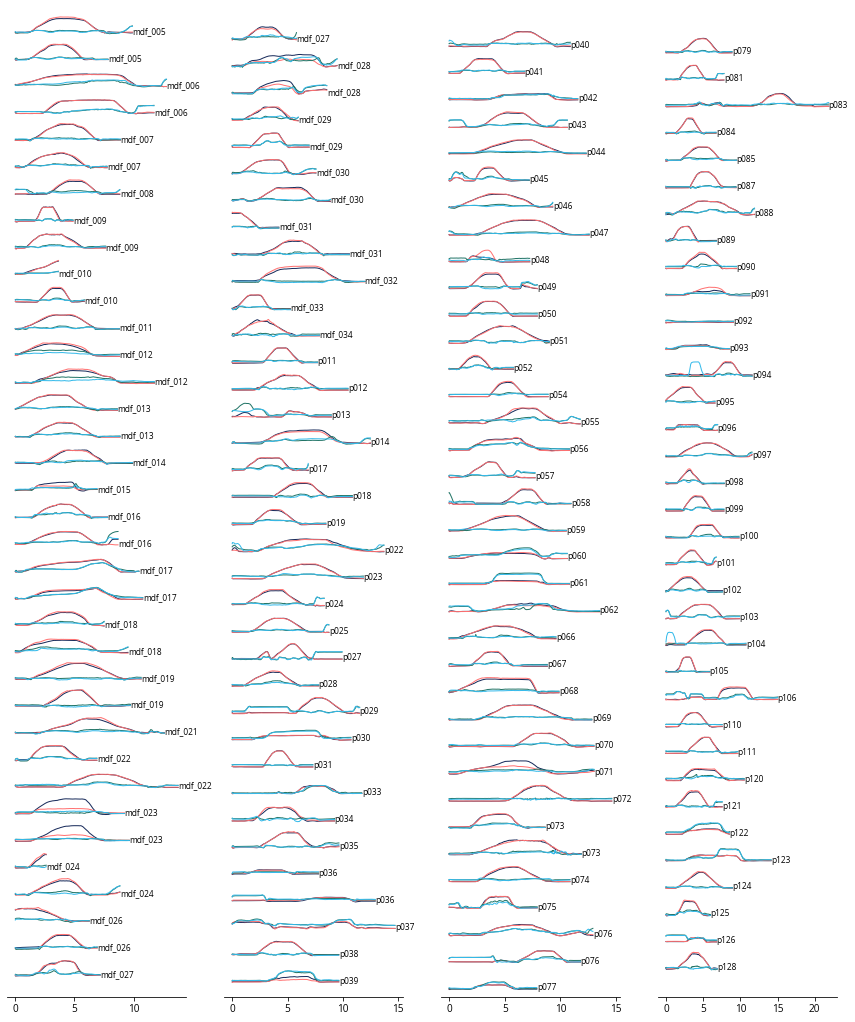

In [67]:
from utils import trc_arm_angles

df_brooke = df_trial[df_trial.trial_clean=='brooke']
n = len(df_brooke)

ncols = 4

plt.figure(figsize=(3*ncols,n/10))

for i in range(n):
    row = df_brooke.iloc[i]
    sid, trial = row.sid, row.trial
    fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))

    rsa, rea, lsa, lea = trc_arm_angles(xyz, markers)
    rsa /= 180
    rea /= 180
    lsa /= 180
    lea /= 180

    t = np.arange(rsa.size) / fps
    pid = row.pid
    
    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t, rsa-i%(n/ncols)*1.5, lw=1, c=cp[0], zorder=-1)
    plt.plot(t, lsa-i%(n/ncols)*1.5, lw=1, c=cp[1], zorder=-1)
    plt.plot(t, rea-i%(n/ncols)*1.5, lw=1, c=cp[2], zorder=-1)
    plt.plot(t, lea-i%(n/ncols)*1.5, lw=1, c=cp[3], zorder=-1)
    plt.text(t[-1], 0-i%(n/ncols)*1.5, pid, fontsize='small')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_brooke.pdf')
plt.show()


In [71]:
sto_fpath = get_sto_fpath(sid, trial)
df = read_mot(sto_fpath)
df.columns


Index(['time', 'pelvis_tilt_moment', 'pelvis_list_moment',
       'pelvis_rotation_moment', 'pelvis_tx_force', 'pelvis_ty_force',
       'pelvis_tz_force', 'hip_flexion_r_moment', 'hip_adduction_r_moment',
       'hip_rotation_r_moment', 'hip_flexion_l_moment',
       'hip_adduction_l_moment', 'hip_rotation_l_moment',
       'lumbar_extension_moment', 'lumbar_bending_moment',
       'lumbar_rotation_moment', 'knee_angle_r_moment',
       'knee_angle_r_beta_force', 'knee_angle_l_moment',
       'knee_angle_l_beta_force', 'sh_tx_r_force', 'sh_ty_r_force',
       'sh_tz_r_force', 'sh_tx_l_force', 'sh_ty_l_force', 'sh_tz_l_force',
       'ankle_angle_r_moment', 'ankle_angle_l_moment',
       'sh_plane_elev_r_moment', 'sh_elev_r_moment', 'sh_axial_rot_r_moment',
       'sh_plane_elev_l_moment', 'sh_elev_l_moment', 'sh_axial_rot_l_moment',
       'subtalar_angle_r_moment', 'subtalar_angle_l_moment',
       'elbow_flex_r_moment', 'elbow_flex_l_moment', 'mtp_angle_r_moment',
       'mtp_angle_

In [102]:
t = df.time.values


0       -0.000014
1        0.008320
2        0.016653
3        0.024986
4        0.033319
          ...    
1241    10.341612
1242    10.349945
1243    10.358278
1244    10.366611
1245    10.374945
Name: time, Length: 1246, dtype: float64

In [118]:
from utils import trc_arm_angles

df_brooke = df_trial[df_trial.trial_clean=='brooke']
df_brooke = df_brooke.iloc[:20]
n = len(df_brooke)

ncols = 6

plt.figure(figsize=(3*ncols,n/6))

for i in range(n):
    row = df_brooke.iloc[i]
    sid, trial = row.sid, row.trial
    df = read_mot(get_mot_fpath(sid, trial))

#     re = df.sh_elev_r_moment.values
#     le = df.sh_elev_l_moment.values
#     # rpe = df.sh_plane_elev_r_moment.values
#     # lpe = df.sh_plane_elev_l_moment.values
    
#     div_factor = 10
#     re /= div_factor
#     le /= div_factor
#     # rpe /= div_factor
#     # lpe /= div_factor
    
#     fps = (len(df)-1) / df.time.values.ptp()
#     W = int(fps) // 2 + 1
#     re = ss.medfilt(re, W)
#     le = ss.medfilt(le, W)
#     # rpe = ss.medfilt(rpe, W)
#     # lpe = ss.medfilt(lpe, W)

#     t = df.time.values
#     pid = row.pid
    
#     plt.subplot(1,ncols,int(i//(n/ncols)+1))
#     plt.plot(t, re-i%(n/ncols)*1.5, lw=1, c=cp[0], zorder=-1)
#     plt.plot(t, le-i%(n/ncols)*1.5, lw=1, c=cp[1], zorder=-1)
#     # plt.plot(t, rpe-i%(n/ncols)*1.5, lw=1, c=cp[2], zorder=-1)
#     # plt.plot(t, lpe-i%(n/ncols)*1.5, lw=1, c=cp[3], zorder=-1)
#     plt.text(t[0], 0-i%(n/ncols)*1.5, pid, fontsize='small', ha='right')
#     plt.yticks([])
#     plt.ylim(-(n/ncols)*1.5, 1.5)

    break

sns.despine(left=True)
plt.tight_layout()
# plt.savefig('demo_brooke_kinematics.pdf')
plt.show()

df.columns


<Figure size 1296x240 with 0 Axes>

Index(['time', 'pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx',
       'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r',
       'hip_rotation_r', 'knee_angle_r', 'knee_angle_r_beta', 'ankle_angle_r',
       'subtalar_angle_r', 'mtp_angle_r', 'hip_flexion_l', 'hip_adduction_l',
       'hip_rotation_l', 'knee_angle_l', 'knee_angle_l_beta', 'ankle_angle_l',
       'subtalar_angle_l', 'mtp_angle_l', 'lumbar_extension', 'lumbar_bending',
       'lumbar_rotation', 'arm_flex_r', 'arm_add_r', 'arm_rot_r',
       'elbow_flex_r', 'pro_sup_r', 'arm_flex_l', 'arm_add_l', 'arm_rot_l',
       'elbow_flex_l', 'pro_sup_l'],
      dtype='object')

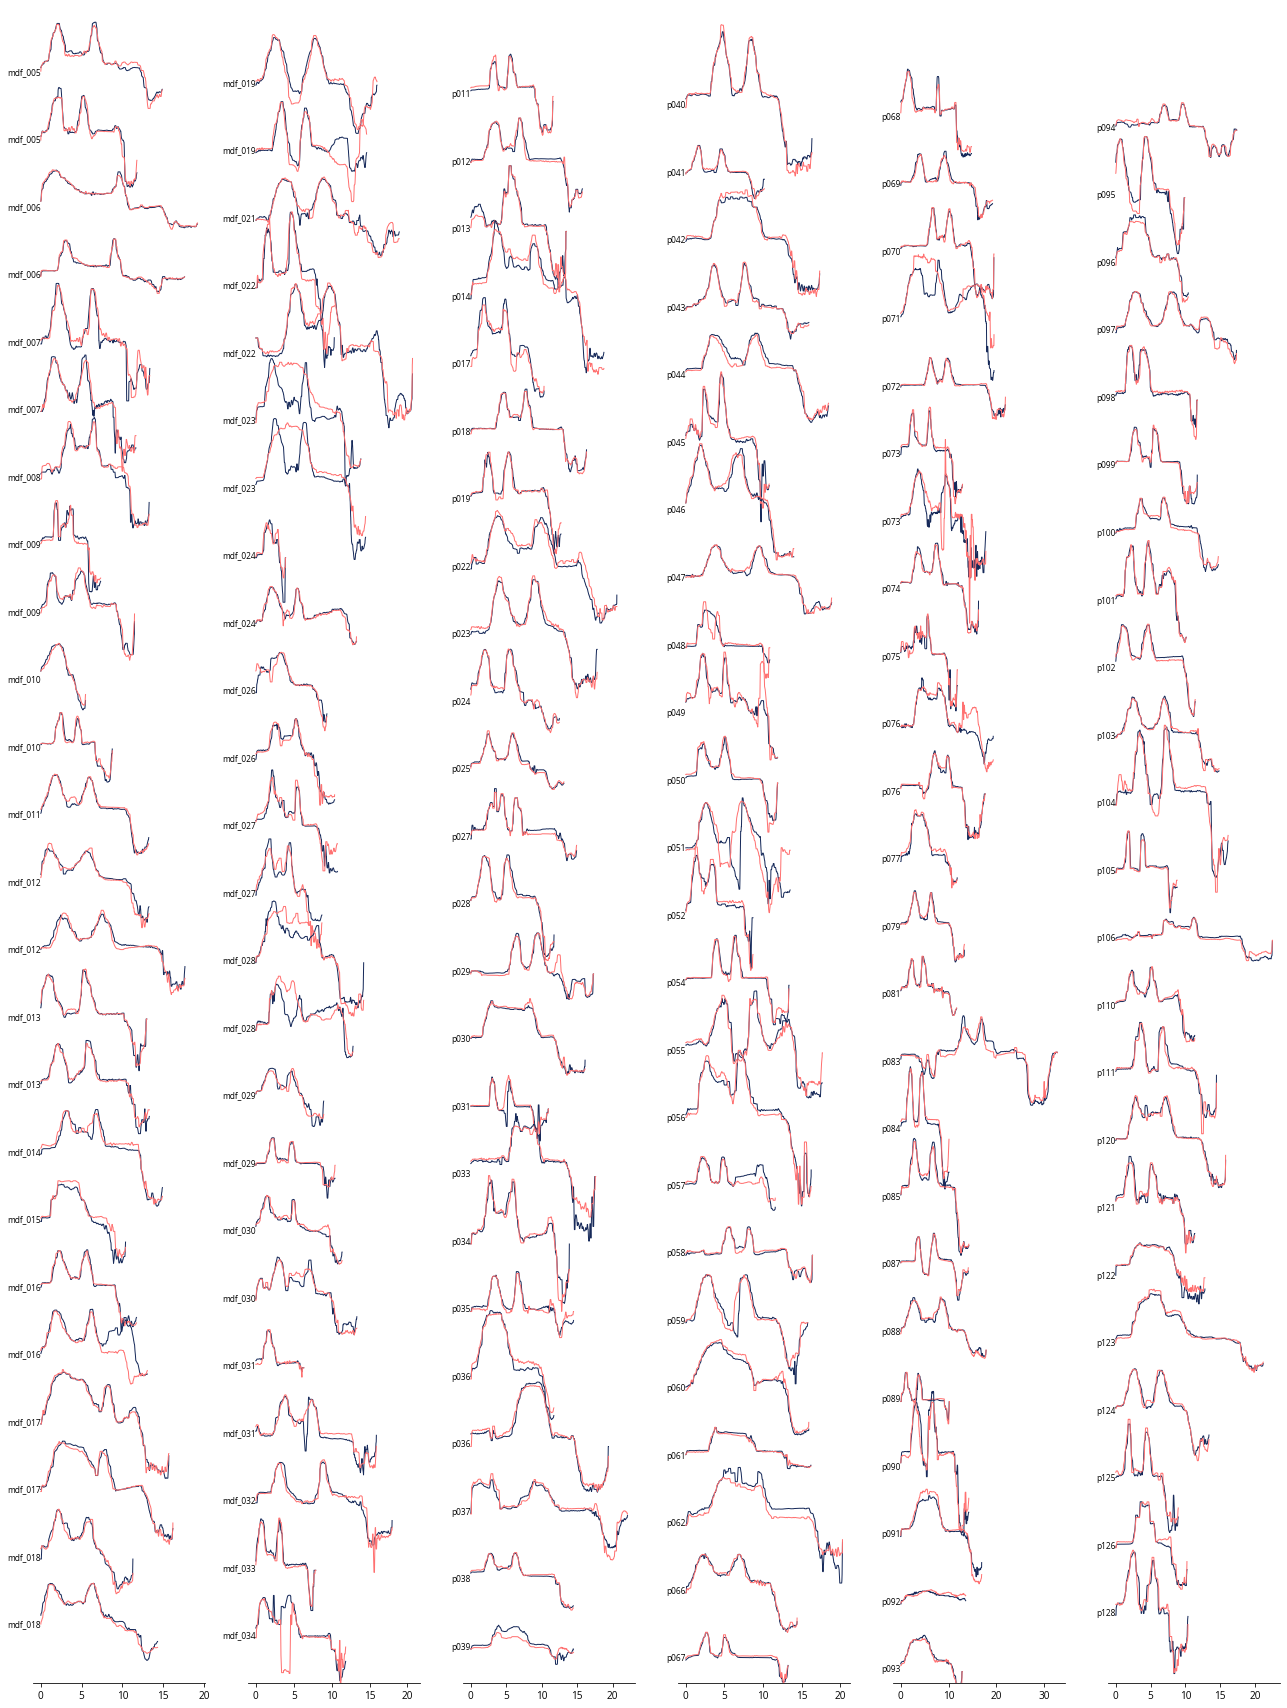

In [115]:
from utils import trc_arm_angles

df_brooke = df_trial[df_trial.trial_clean=='brooke']
# df_brooke = df_brooke.iloc[:20]
n = len(df_brooke)

ncols = 6

plt.figure(figsize=(3*ncols,n/6))

for i in range(n):
    row = df_brooke.iloc[i]
    sid, trial = row.sid, row.trial
    df = read_mot(get_sto_fpath(sid, trial))

    re = df.sh_elev_r_moment.values
    le = df.sh_elev_l_moment.values
    # rpe = df.sh_plane_elev_r_moment.values
    # lpe = df.sh_plane_elev_l_moment.values
    
    div_factor = 10
    re /= div_factor
    le /= div_factor
    # rpe /= div_factor
    # lpe /= div_factor
    
    fps = (len(df)-1) / df.time.values.ptp()
    W = int(fps) // 2 + 1
    re = ss.medfilt(re, W)
    le = ss.medfilt(le, W)
    # rpe = ss.medfilt(rpe, W)
    # lpe = ss.medfilt(lpe, W)

    t = df.time.values
    pid = row.pid
    
    plt.subplot(1,ncols,int(i//(n/ncols)+1))
    plt.plot(t, re-i%(n/ncols)*1.5, lw=1, c=cp[0], zorder=-1)
    plt.plot(t, le-i%(n/ncols)*1.5, lw=1, c=cp[1], zorder=-1)
    # plt.plot(t, rpe-i%(n/ncols)*1.5, lw=1, c=cp[2], zorder=-1)
    # plt.plot(t, lpe-i%(n/ncols)*1.5, lw=1, c=cp[3], zorder=-1)
    plt.text(t[0], 0-i%(n/ncols)*1.5, pid, fontsize='small', ha='right')
    plt.yticks([])
    plt.ylim(-(n/ncols)*1.5, 1.5)

sns.despine(left=True)
plt.tight_layout()
plt.savefig('demo_brooke_moments.pdf')
plt.show()
